## Adversarial attacks - hyperspectral model HybridSN
This notebook demonstrates adversarial attacks on the trained HybridSN model using the Indian Pines (IP) dataset.

In [20]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import DataLoader, Dataset

from attacks.cw import CW
from attacks.deepfool import DeepFool
from attacks.fgsm import FGSM
from attacks.pgd import PGD

In [21]:
BATCH_SIZE = 32 # How many images to process at once
NUM_IMAGES = 8192 # How many images to process in total
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check device
print(f"Using device: {DEVICE}")

Using device: cpu


In [22]:
if NUM_IMAGES > 10249:
    raise ValueError("NUM_IMAGES must be less than or equal to 10249, the number of images in the dataset.")

In [23]:
# Load IP dataset and preprocess (PCA, patch extraction)
def load_ip_data():
    data_path = os.path.join(os.getcwd(), "data", "IndianPines")
    data = loadmat(os.path.join(data_path, "Indian_pines_corrected.mat"))["indian_pines_corrected"]
    labels = loadmat(os.path.join(data_path, "Indian_pines_gt.mat"))["indian_pines_gt"]

    # PCA
    pca = PCA(n_components=15, whiten=True)
    newX = np.reshape(data, (-1, data.shape[2]))
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (data.shape[0], data.shape[1], 15))
    return newX, labels

In [24]:
class PatchSet(Dataset):
    def __init__(self, data, gt, patch_size):
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data, ((p,p),(p,p),(0,0)), "constant")
        self.label = np.pad(gt, (p,p), "constant")
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos, strict=False)])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype="float32").transpose((2, 0, 1))
        label = np.asarray(label, dtype="int64")
        return torch.from_numpy(data), torch.from_numpy(label)

In [25]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))

        self.x1_shape = self.get_shape_after_3dconv()

        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],
                              out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()

        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))

        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))

        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums),
                   )

    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2],
                         self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
        return x.shape[1]*x.shape[2]*x.shape[3]

    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape

    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])

        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)

        x = self.dense1(x)
        x = self.dense2(x)

        return self.dense3(x)

In [26]:
N_PCA = 15
PATCH_SIZE = 25
NUM_CLASS = 16

model = HybridSN(N_PCA, PATCH_SIZE, class_nums=NUM_CLASS)
model.load_state_dict(torch.load("model/ip_final_weights.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Prepare test data
ip_data, ip_labels = load_ip_data()
test_gt = (ip_labels > 0).astype(np.int64) * ip_labels
test_data = PatchSet(ip_data, test_gt, PATCH_SIZE)
test_data = torch.utils.data.Subset(test_data, range(NUM_IMAGES))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Helper function to evaluate adversarial attacks
def evaluate_attack(attack, test_loader, model, device):
    correct = 0
    total = 0
    l2_list = []
    linf_list = []
    start_time = time.time()
    for data, target in test_loader:
        data, target = data.to(device), (target-1).to(device)
        adv_data = attack(data, target)
        output = model(adv_data)
        _, pred = torch.max(output, 1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        perturb = (adv_data - data).view(data.size(0), -1)
        l2_list.extend(torch.norm(perturb, p=2, dim=1).cpu().numpy())
        linf_list.extend(torch.norm(perturb, p=float("inf"), dim=1).cpu().numpy())
    acc = correct / total
    elapsed = time.time() - start_time
    return acc, np.mean(l2_list), np.mean(linf_list), elapsed

In [28]:
# Dictionaries to hold results
perturbation_results = {}
attack_times = {}

## Fixed parameters

In [29]:
# FGSM
FGSM_EPSILON = 0.01

# PGD
PGD_EPSILON = 0.01
PGD_ALPHA = 0.003
PGD_STEPS = 1

# CW
CW_C = 100
CW_KAPPA = 0
CW_STEPS = 20
CW_LR = 0.05

# DeepFool
DF_STEPS = 1
DF_OVERSHOOT = 0.01
NUM_CLASSES = NUM_CLASS

## FGSM Attack
Apply FGSM to the test set and evaluate the model's accuracy on adversarial examples.

In [30]:
fgsm = FGSM(model, eps=FGSM_EPSILON, clip_min=0.0, clip_max=1.0)
fgsm_acc, fgsm_l2, fgsm_linf, fgsm_time = evaluate_attack(fgsm, test_loader, model, DEVICE)
perturbation_results["FGSM"] = (fgsm_l2, fgsm_linf)
attack_times["FGSM"] = fgsm_time

## PGD Attack
Apply PGD to the test set and evaluate the model's accuracy on adversarial examples.

In [31]:
pgd = PGD(model, eps=PGD_EPSILON, alpha=PGD_ALPHA, steps=PGD_STEPS, clip_min=0.0, clip_max=1.0)
pgd_acc, pgd_l2, pgd_linf, pgd_time = evaluate_attack(pgd, test_loader, model, DEVICE)
perturbation_results["PGD"] = (pgd_l2, pgd_linf)
attack_times["PGD"] = pgd_time

## CW Attack
Apply CW to the test set and evaluate the model's accuracy on adversarial examples.

In [32]:
cw = CW(model, c=CW_C, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR, clip_min=0.0, clip_max=1.0)
df_cw_acc, cw_l2, cw_linf, cw_time = evaluate_attack(cw, test_loader, model, DEVICE)
perturbation_results["CW"] = (cw_l2, cw_linf)
attack_times["CW"] = cw_time

## DeepFool Attack
Apply DeepFool to the test set and evaluate the model's accuracy on adversarial examples.

In [33]:
deepfool = DeepFool(model, steps=DF_STEPS, overshoot=DF_OVERSHOOT, num_classes=NUM_CLASSES, clip_min=0.0, clip_max=1.0)
df_deepfool_acc, deepfool_l2, deepfool_linf, deepfool_time = evaluate_attack(deepfool, test_loader, model, DEVICE)
perturbation_results["DeepFool"] = (deepfool_l2, deepfool_linf)
attack_times["DeepFool"] = deepfool_time

## Clean accuracy
Calculate accuracy on clean images for comparison

In [34]:
# Compute clean accuracy
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    output = model(data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

clean_acc = correct / total

## Results
Display accuracies of FGSM, PGD, CW, DeepFool attacks versus clean accuracy.

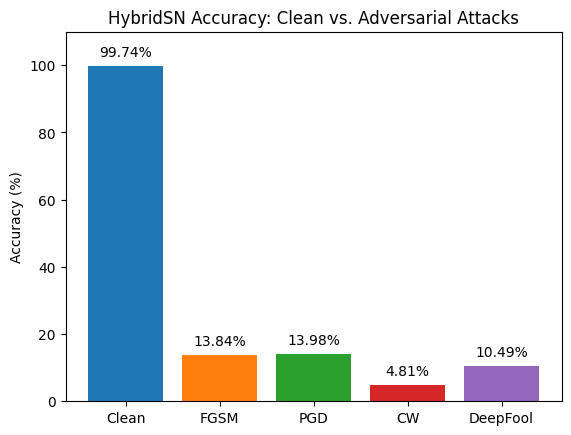

In [35]:
# Plot histogram with y-axis in percent and value labels
labels = ["Clean", "FGSM", "PGD", "CW", "DeepFool"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
accuracies = [clean_acc, fgsm_acc, pgd_acc, df_cw_acc, df_deepfool_acc]
percentages = [a * 100 for a in accuracies]

bars = plt.bar(labels, percentages, color=colors)
plt.ylim(0, 110)
plt.ylabel("Accuracy (%)")
plt.title("HybridSN Accuracy: Clean vs. Adversarial Attacks")

# Add value labels
for bar, pct in zip(bars, percentages, strict=False):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 2,
             f"{pct:.2f}%", ha="center", va="bottom")

plt.show()

In [36]:
print(f"Clean Accuracy: {clean_acc:.4f}")
print(f"FGSM Accuracy: {fgsm_acc:.4f}")
print(f"PGD Accuracy: {pgd_acc:.4f}")
print(f"CW Accuracy: {df_cw_acc:.4f}")
print(f"DeepFool Accuracy: {df_deepfool_acc:.4f}")

Clean Accuracy: 0.9974
FGSM Accuracy: 0.1384
PGD Accuracy: 0.1398
CW Accuracy: 0.0481
DeepFool Accuracy: 0.1049


## Execution time
Plot execution time for each attack

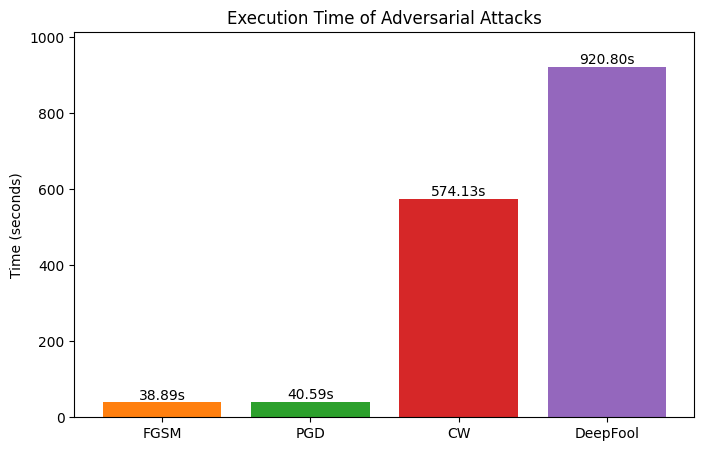

In [37]:
labels = list(attack_times.keys())
times = [attack_times[k] for k in labels]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, times, color=["#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.ylabel("Time (seconds)")
plt.title("Execution Time of Adversarial Attacks")

plt.ylim(0, max(times) * 1.1)

# Add value labels
for bar, t in zip(bars, times, strict=False):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.05,
             f"{t:.2f}s", ha="center", va="bottom")

plt.show()

## Calculate L2, L-inf norms
Calculate and compare average perturbation magnitudes for each attack

Average perturbation magnitude (L2 norm, Linf norm):
FGSM: L2 = 69.4104, Linf = 4.1215
PGD: L2 = 69.4092, Linf = 4.1215
CW: L2 = 64.9486, Linf = 3.9354
DeepFool: L2 = 69.6666, Linf = 4.1215


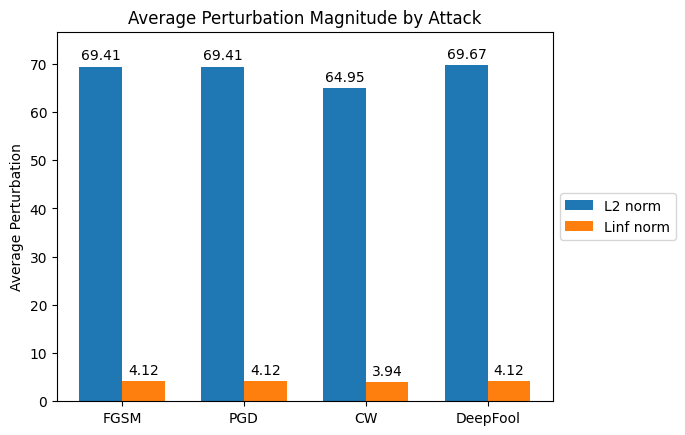

In [38]:
# Print results
print("Average perturbation magnitude (L2 norm, Linf norm):")
for attack, (l2, linf) in perturbation_results.items():
    print(f"{attack}: L2 = {l2:.4f}, Linf = {linf:.4f}")

# Plot bar chart for L2 and Linf
labels = list(perturbation_results.keys())
l2_vals = [perturbation_results[k][0] for k in labels]
linf_vals = [perturbation_results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l2_vals, width, label="L2 norm")
rects2 = ax.bar(x + width/2, linf_vals, width, label="Linf norm")

ax.set_ylabel("Average Perturbation")
ax.set_title("Average Perturbation Magnitude by Attack")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

max_val = max(*l2_vals, *linf_vals)
ax.set_ylim(0, max_val * 1.1)

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")
for rect in rects2:
    height = rect.get_height()
    ax.annotate(f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")
plt.show()